# 0 Table of Contents

1. [Setup](#1-setup)
    1. [Import](#11-imports)
    2. [Resources](#12-resources)
    3. [Load Data](#13-load-data)
2. [Prepare Data](#2-prepare-data)
3. [Time Series Analysis on Sales](#3-time-series-analysis-on-sales)
    1. [Line Chart](#31-line-chart)
    2. [Decomposition](#32-decomposition)
    3. [Stationarizing Using Differencing](#34-stationarizing-using-differencing)
    4. [Autocorrelation](#35-autocorrelation)

# 1 Setup [(#)](#0-table-of-contents)

## 1.1 Imports [(#)](#0-table-of-contents)

In [2]:
import sys
import os
from  pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, r"C:\Users\vynde\PycharmProjects\dataanalysis")
import databridger as da 

## 1.2 Resources [(#)](#0-table-of-contents)

In [3]:
raw_data_folder = Path('..') / 'data' / 'raw'
report_folder = Path('..') / 'reports'

## 1.3 Load Data [(#)](#0-table-of-contents)

Load database with databriger

In [4]:
db_csv = da.Database(raw_data_folder)

Convert datetime variables

In [5]:
for key in db_csv.tables:
    for column in db_csv.tables[key].columns:
        if db_csv.tables[key][column].dtype == 'object':
            if all(db_csv.tables[key][column].str.match(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}")):
                db_csv.tables[key][column] = pd.to_datetime(db_csv.tables[key][column])
                print(f"converted:   {key:15} / {column:30} from object to {db_csv.tables[key][column].dtype}")

converted:   olist_orders_dataset / order_purchase_timestamp       from object to datetime64[ns]
converted:   olist_orders_dataset / order_approved_at              from object to datetime64[ns]
converted:   olist_orders_dataset / order_delivered_carrier_date   from object to datetime64[ns]
converted:   olist_orders_dataset / order_delivered_customer_date  from object to datetime64[ns]
converted:   olist_orders_dataset / order_estimated_delivery_date  from object to datetime64[ns]
converted:   olist_order_items_dataset / shipping_limit_date            from object to datetime64[ns]
converted:   olist_order_reviews_dataset / review_creation_date           from object to datetime64[ns]
converted:   olist_order_reviews_dataset / review_answer_timestamp        from object to datetime64[ns]


Rename tables

In [6]:
table_names = list(db_csv.tables.keys())

# remove 'olist_' and '_dataset' in table_names
new_table_names = (
    list(map(
        lambda x: x.removeprefix("olist_").removesuffix("_dataset"), 
        table_names
    ))
)

# overwrite table names in db_csv
db_csv.tables = dict(zip(new_table_names, db_csv.tables.values()))

db_csv.tables.keys()

dict_keys(['customers', 'geolocation', 'orders', 'order_items', 'order_payments', 'order_reviews', 'products', 'sellers', 'product_category_name_translation'])

Overview

In [7]:
db_csv.update_columns_mapping(["geolocation_zip_code_prefix"])

Column and table mappings need to be corrected. Current implementation of the Database class for csv files does not construct a compatible columns_mapping for using its easy_merge method.

Therefore, table-column-pairs just need to be swapped and concatenated

In [8]:
# original mapping
df1 = db_csv.columns_mapping[["from_table", "from_column", "to_table", "to_column"]]
# swapped version
df2 = db_csv.columns_mapping[["to_table", "to_column", "from_table", "from_column"]]

# Renaming columns to match the df1's columns
df2.columns = ["from_table", "from_column", "to_table", "to_column"]

# new mapping
adjusted_columns_mapping = pd.concat([df1, df2], ignore_index=True).drop_duplicates()

# apply the new mapping to the Database instance
db_csv.columns_mapping = adjusted_columns_mapping

# this is copy/pasted from the Database class directly
db_csv.table_mapping = dict(db_csv.columns_mapping[["from_table", "to_table"]].groupby("from_table")["to_table"].apply(list))

# 2 Prepare Data [(#)](#0-table-of-contents)

Merge tables into one dataframe

In [23]:
table_names = ["orders", "order_items", "order_payments", "products", "product_category_name_translation"]
table_names = ["orders", "order_payments"]
tables = [db_csv.tables[table_name] for table_name in table_names]

for table in tables:
    print(table.shape, table.columns.tolist())

df = tables[0]
for table in tables[1:]:
    df = df.merge(table, how="outer")

print(df.shape)

(99441, 8) ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
(103886, 5) ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
(103887, 12)


Aggregate Data

In [24]:
aggregated_data = df.groupby(df['order_purchase_timestamp'].dt.date).agg(
    total_sales_value=pd.NamedAgg(column='payment_value', aggfunc='sum'),
    number_of_orders=pd.NamedAgg(column='order_id', aggfunc='nunique')
).reset_index()
aggregated_data.head()

,order_purchase_timestamp,total_sales_value,number_of_orders
0,2016-09-04,136.23,1
1,2016-09-05,75.06,1
2,2016-09-13,40.95,1
3,2016-09-15,0.00,1
4,2016-10-02,109.34,1


# 3 Time Series Analysis on Sales [(#)](#0-table-of-contents)

## 3.1 Line Chart [(#)](#0-table-of-contents)

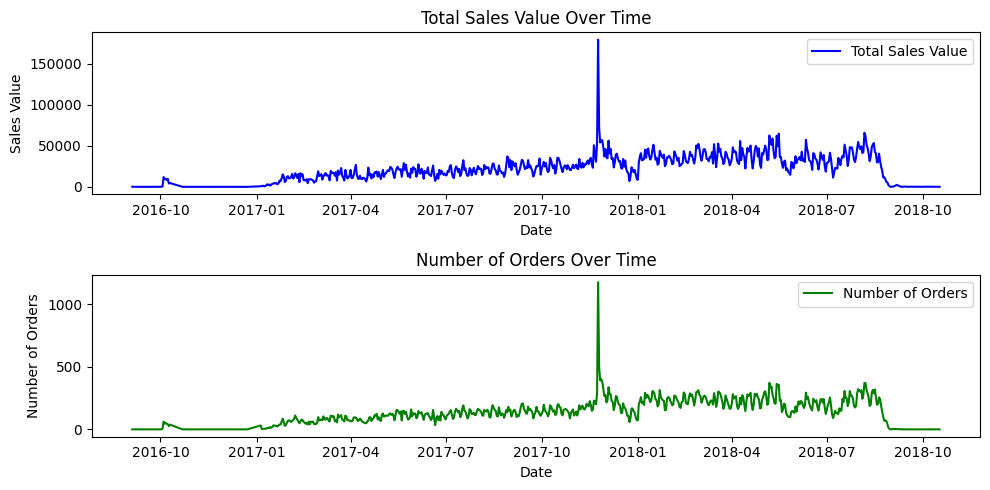

In [25]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

# Plot total sales value over time
ax[0].plot(aggregated_data['order_purchase_timestamp'], aggregated_data['total_sales_value'], label='Total Sales Value', color='blue')
ax[0].set_title('Total Sales Value Over Time')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Sales Value')
ax[0].legend()

# Plot number of orders over time
ax[1].plot(aggregated_data['order_purchase_timestamp'], aggregated_data['number_of_orders'], label='Number of Orders', color='green')
ax[1].set_title('Number of Orders Over Time')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Number of Orders')
ax[1].legend()

plt.tight_layout()
plt.show()


1. **Total Sales Value Over Time**: The blue plot displays the total sales value for each day. It seems there are some peaks in sales, which might indicate special events, promotions, or seasonality. The general trend appears to be upward, indicating growth in sales over time.
2. **Number of Orders Over Time**: The green plot displays the number of orders for each day. Similar to the sales value, we see peaks, which might be due to the same reasons.

Somewhere at the end of 2018 there is a sales peak which should be clarified. At the beginning and end of the data there are phases with zero values. It's possible that during this period, there was an issue in the data collection process or operational halts. These should be excluded when considering forecasting.

In [26]:
# Identify the date with the highest total sales value
peak_date = aggregated_data['order_purchase_timestamp'][aggregated_data['total_sales_value'].idxmax()]

# Extract data around the peak (let's take a window of 7 days before and after the peak date)
window = 2
mask = (aggregated_data['order_purchase_timestamp'] >= (peak_date - pd.Timedelta(days=window))) & \
       (aggregated_data['order_purchase_timestamp'] <= (peak_date + pd.Timedelta(days=window)))

peak_data = aggregated_data[mask]

peak_data


,order_purchase_timestamp,total_sales_value,number_of_orders
336,2017-11-22,30721.62,201
337,2017-11-23,52584.62,283
338,2017-11-24,179200.03,1176
339,2017-11-25,71897.01,499
340,2017-11-26,53939.87,391


The peak date is November 24, which was **Black Friday** in 2017, a major shopping event in many countries.

## 3.2 Decomposition [(#)](#0-table-of-contents)

C:\Users\vynde\AppData\Local\Temp\ipykernel_70408\2158168440.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


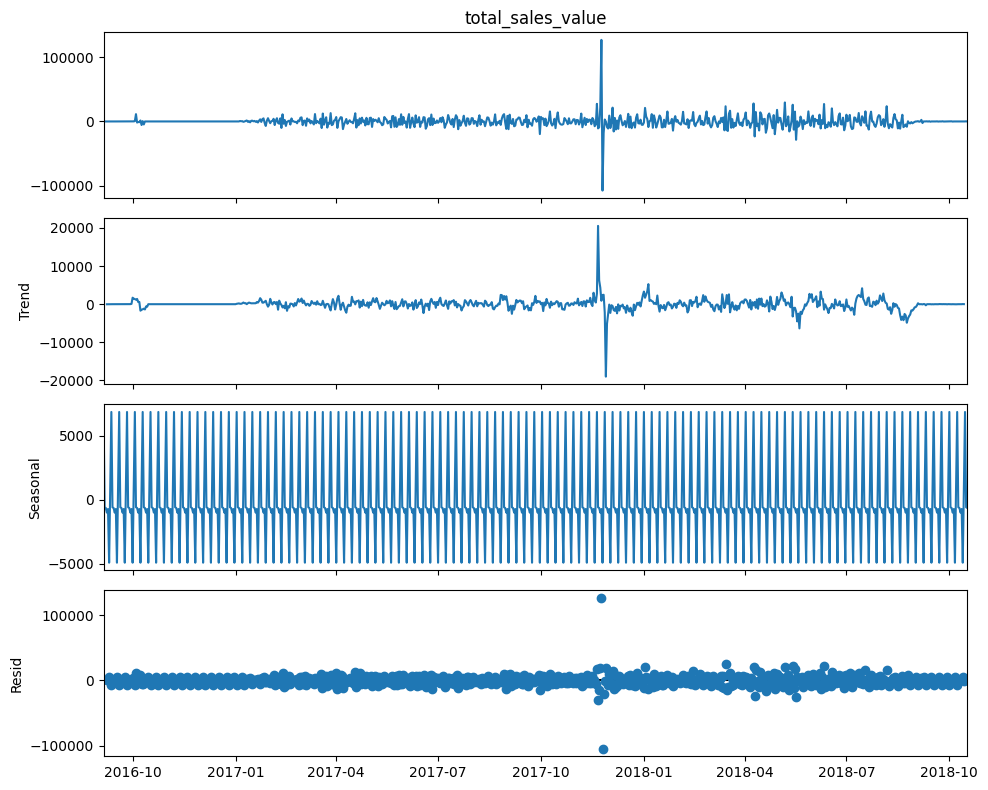

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Reset the index and then set it again as a DatetimeIndex
aggregated_data.reset_index(inplace=True)
aggregated_data.set_index(pd.to_datetime(aggregated_data['order_purchase_timestamp']), inplace=True)

# Resample the data to daily frequency and fill missing values with zeros
daily_sales = aggregated_data['total_sales_value'].resample('D').sum().fillna(0)

# Decompose the time series again
result = seasonal_decompose(daily_sales.diff().dropna(), model='additive')

# Plot the decomposition
fig = result.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()



1. **Trend**: This represents the underlying trend in the data. We can see a general upward trend over time, suggesting a growth in sales.
2. **Seasonal**: This captures the seasonality in the data. There seems to be a recurring pattern, which could be weekly or monthly seasonality.
3. **Residual**: These are the residuals or "noise" in the data after removing the trend and seasonality. Ideally, we'd want this to be as random as possible, with no discernible patterns.

## 3.3 Stationarity Test [(#)](#0-table-of-contents)

Next, let's check the stationarity of our time series data using the Augmented Dickey-Fuller (ADF) test. The null hypothesis of the ADF test is that the time series is non-stationary. A low p-value (typically ≤ 0.05) rejects the null hypothesis, indicating the time series is stationary.

In [14]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_result = adfuller(daily_sales)

# Extract p-value
adf_pvalue = adf_result[1]

adf_pvalue


0.2655937044772656

This is greater than the commonly used significance level of 0.05, which means we fail to reject the null hypothesis. Therefore, the time series is likely non-stationary.

## 3.4 Stationarizing using Differencing [(#)](#0-table-of-contents)

To make the time series stationary, a common approach is to take the first difference of the series. This means subtracting the previous value from the current value. Let's apply this transformation and then retest for stationarity.

In [15]:
# Calculate the first difference of the time series
daily_sales_diff = daily_sales.diff().dropna()

# Perform ADF test on the differenced series
adf_result_diff = adfuller(daily_sales_diff)

# Extract p-value for the differenced series
adf_pvalue_diff = adf_result_diff[1]

adf_pvalue_diff


5.688371967121538e-13

The p-value from the Augmented Dickey-Fuller (ADF) test on the differenced series is now significantly less than 0.05. This indicates that the first difference of the series is stationary.

## 3.5 Autocorrelation [(#)](#0-table-of-contents)

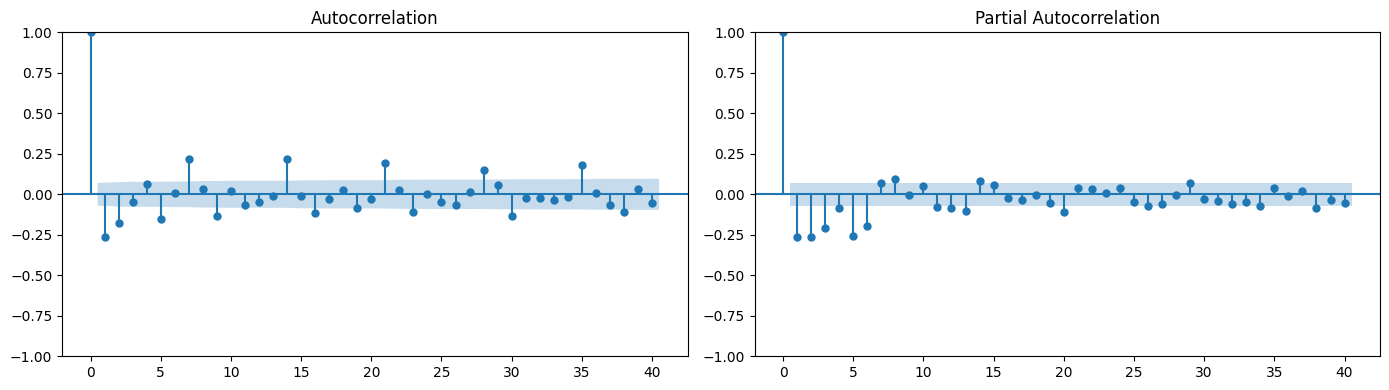

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Plot ACF
plot_acf(daily_sales_diff, lags=40, ax=ax[0])

# Plot PACF
plot_pacf(daily_sales_diff, lags=40, ax=ax[1])

plt.tight_layout()
plt.show()


1. **ACF Plot**: This plot shows the correlation of the time series with its own lags. The spikes represent the degree of correlation for each lag. We can see a significant spike at lag 7, suggesting a weekly pattern, which is common for sales data.
2. **PACF Plot**: This plot shows the correlation of the time series with its lags after removing the effects of previous lags. The spikes in the PACF can help in determining the order of the autoregressive (AR) term for ARIMA models.

# 4 Data Export

In [20]:
df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
df.columns = ['observed', 'trend', 'seasonal', 'resid']
df.to_csv(Path('..') / 'data' / 'prepared' / 'timeseries_decomposed.csv')